In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

from functools import partial
import jax.numpy as jnp
from jax import lax, vmap
from jax.scipy.stats import multivariate_normal
import jax.random as jrandom
import blackjax

import numpy as np

key = jrandom.PRNGKey(123)

# No-U-Turn Sampler with Blackjax

TODO: You can do the catalysis problem with blackjax, but keep the sigma fixed.

In [2]:
def banana_logdensity(x, a=1.15, b=0.5, rho=0.5):
    """A banana-shaped distribution. Comes from a nonlinear transformation of a correlated Gaussian."""
    x1, x2 = x
    u1 = x1/a
    u2 = a*(x2 - b*(u1**2 + a**2))
    return multivariate_normal.logpdf(jnp.array([u1, u2]), jnp.zeros(2), jnp.array([[1, rho], [rho, 1]]))

def plot_2d_function(f, alpha=1.0, plot_type="pcolormesh", ax=None, levels=None):
    x = jnp.linspace(-4, 4, 100)
    y = jnp.linspace(-1, 11, 100)
    X, Y = jnp.meshgrid(x, y)
    Z = vmap(f)(jnp.stack([X.flatten(), Y.flatten()], axis=1)).reshape(X.shape)

    if ax is None:
        _, ax = plt.subplots()
    if plot_type == "contour":
        ax.contour(X, Y, jnp.exp(Z), alpha=alpha, cmap="Greens", levels=levels)
    elif plot_type == "pcolormesh":
        ax.pcolormesh(X, Y, jnp.exp(Z), alpha=alpha)
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([0, 2, 4, 6])
    ax.set_aspect("equal")
    sns.despine(trim=True, left=True, bottom=True)
    return ax

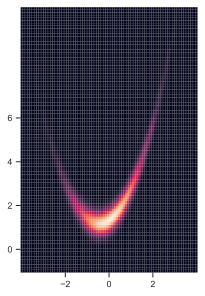

In [3]:
banana_logdensity_high_curv = partial(banana_logdensity, a=1.15, b=1.0, rho=0.9)
plot_2d_function(banana_logdensity_high_curv);

## No-U-Turn Sampler (NUTS) recap

In [4]:
# HMC hyperparameters
step_size = 0.1
inverse_mass_matrix = jnp.eye(2)

# Create the HMC kernel
nuts = blackjax.nuts(
    banana_logdensity_high_curv, step_size, inverse_mass_matrix
)

def step(state, _):
    """A single step of the Hamiltonian Monte Carlo sampler. Used with `lax.scan`."""
    key, kernel_state = state
    key, subkey = jrandom.split(key)
    kernel_state, info = nuts.step(subkey, kernel_state)
    return (key, kernel_state), (kernel_state.position, info)

def run_mcmc_chain(key, init_state, num_samples):
    """Run a chain of MCMC."""
    _, (samples, info) = lax.scan(step, (key, init_state), None, length=num_samples)
    return samples, info

In [5]:
num_chains = 5
num_samples_per_chain = 200

key, key_run, key_init = jrandom.split(key, 3)
keys = jrandom.split(key_run, num_chains)
init_state_spread = 2.0
init_state = vmap(nuts.init)(init_state_spread*jrandom.normal(key_init, (num_chains, 2)))
samples, info = vmap(run_mcmc_chain, in_axes=(0, 0, None))(keys, init_state, num_samples_per_chain)

Let's make the trace plot (with the help of the [`arviz`](https://python.arviz.org/en/stable/) library):

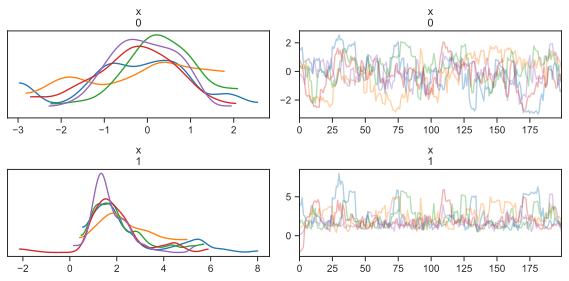

In [6]:
import arviz as az
az.plot_trace(np.array(samples[:, :]), compact=False, backend_kwargs=dict(figsize=(8,4), tight_layout=True));

Let's look at $\hat{R}$ to assess convergence (see the Metropolis-Hastings hands-on activity for more details):

In [7]:
compute_diagnostics_every = 10
rhats = []
for i in range(2, num_samples_per_chain, compute_diagnostics_every):
    rhat = blackjax.diagnostics.potential_scale_reduction(samples[:, :i])
    rhats.append(rhat)
rhats = jnp.array(rhats)

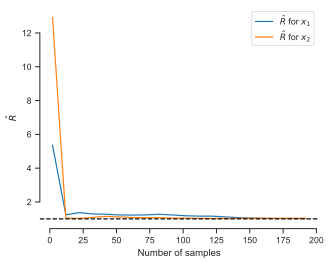

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), rhats[:,0], label=r"$\hat{R}$ for $x_1$")
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), rhats[:,1], label=r"$\hat{R}$ for $x_2$")
ax.axhline(1.0, color="black", linestyle="--")
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"$\hat{R}$")
ax.legend()
sns.despine(trim=True)

It looks like the chains converge fairly quickly.

Let's look at the effective sample size (ESS) to see how many independent samples we have (again, see the Metropolis-Hastings hands-on activity for more details):

In [9]:
n_effs = []
for i in range(2, num_samples_per_chain, compute_diagnostics_every):
    n_eff = blackjax.diagnostics.effective_sample_size(samples[:, :i])
    n_effs.append(n_eff)
n_effs = jnp.array(n_effs)

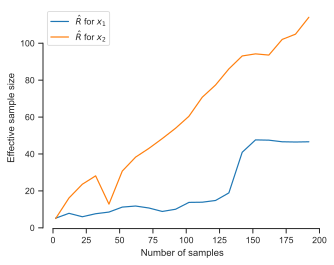

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), n_effs[:,0], label=r"$\hat{R}$ for $x_1$")
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), n_effs[:,1], label=r"$\hat{R}$ for $x_2$")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Effective sample size")
ax.legend()
sns.despine(trim=True)

The ESS is very high. This is good&mdash;it means that our samples are not correlated, and we don't have to thin them out.

Finally, let's plot the samples:

In [11]:
# The original shape of the `samples` array is (n_chains, n_samples, n_dim)
burn_in = 50  # Remove first N samples
thin = 1  # Only keep every M samples
true_samples = samples[:, burn_in::thin]

# Concatenate the chains. Final shape is (n_chains * n_true_samples_per_chain, n_dim)
true_samples = true_samples.reshape(-1, 2)

In [12]:
x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-3, 7, 100)
X, Y = jnp.meshgrid(x, y)
Z = vmap(banana_logdensity)(jnp.stack([X.flatten(), Y.flatten()], axis=1)).reshape(X.shape)

ax = plot_2d_function(banana_logdensity_high_curv, alpha=0.4);
ax.set_title("MCMC samples from \nthe original distribution", fontsize=16)
ax.scatter(true_samples[:, 0], true_samples[:, 1], s=2, alpha=0.5);